In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# Control with TD Value Function Approximation

Here, we want to us TD learning for function approximation of the action value function and then apply $\epsilon$-greedy to choose the next action.

To illustrate this, we implement the mountain car example from the RL Lecture 6 by David Silver for action value function approximation [see example](https://youtu.be/UoPei5o4fps)


We use a linear action function approximation. That is, the action value function is represented by a linear combination of features
$$
\hat q(S,A,w) = x(S,A)^T \cdot w = \sum_{j=1}^n x_j(S,A) \cdot w_j
$$

The objective function to minimizes is then 
$$
J(w) = \mathbb{E}_{\pi} \left [ (q_{\pi}(S,A) - x(S,A)^T \cdot w)^2 \right ]
$$

and we can use stochastic gradien descent to do so. The derivation of the action value function is :
$$
 \bigtriangledown_w \hat q(S,A,w) = x(S,A)
$$

and the weight update rule is:

$$
\Delta w = \alpha (q_{\pi}(S,A) - \hat q(S,A,w)) \cdot x(S,A)
$$

if we assume that we know $q(S,A)$ which is normally __not__ the case. 
However, we can substitute $q(S,A)$ with a target from one of the value function evaluation algorithms (MC, TD etc.).

For TD(0) learning we substitute $q_{\pi}(S,A)$ the TD target:
$$
\Delta w = \alpha (\color{red}{ R_{t+1} + \gamma \hat q(S_{t+1}, A_{t+1}, w)} - \hat q(S_t, A_t,w)) \cdot x(S_t,A_t)
$$

### Important

The way states and actions are represented in the feature vector $x(S,A)$ is very crucial for the success of the learning. 
Sutton \& Barto use tile-coding (a form of coarse coding) for the moutain car problem (see page 217 of their RL book). For this example (see page 245), they used 8 tilings with each tile covering 1/8th of the bounded distance in each dimension (position,velocity,action). For that, we use their python script `tiles3.py`. Each tiling has  8 (tiling) x 8 (position) x 8 (velocity) x 8 (action) = 4096    tiles. 
The feature vector $x$ is binary with $1$ if the feature (combination of position,velocity and action) is in a specific tile. 





In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotting
import random
from operator import itemgetter
import time
import tiles3
plotting.set_layout(drawing_size=15)

import warnings

warnings.filterwarnings('error')

## The Environment

For this example we use the python package [gym](https://gym.openai.com/docs/) which provides a ready-to-use implementation of a mountain car environment.

The states are stored in this tuple format: (car position, car velocity)

Here, we can look at the number of different states:

In [3]:
import gym
env = gym.make('MountainCar-v0')
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

And the number of actions we can take:
* 0 :     Accelerate to the Left
* 1 :     Don't accelerate
* 2 :     Accelerate to the Right

In [4]:
env.action_space

Discrete(3)

To start a game call `env.reset()` which will set the car at a random position with velocity 0

In [5]:
env.reset()

array([-0.42353206,  0.        ])

The result of this function call shows the _obersavtion space_, the reward (goal accomplished) and if the game is over. The game is over if the agent reaches the goal (car position > 0.5) or after 200 time steps.

In [6]:
state , reward, goal_reached, _ = env.step(2)
env.render()

print(state,reward, goal_reached)

[-4.23271342e-01  2.60721502e-04] -1.0 False


## Define the Agent



In [22]:

class agents():
    """ This class defines the agent 
    """
    
    def __init__(self,epsilon=1.0):
        """ n_x: defines the width of the environment
            n_y: defones the height of the environment
            pos_start: defines the starting position of the agent (x-,y-position)
            gamma: the discount factor            """ 
        
        # Store the discount factor 
        self.gamma = 1
        # Store the update rate
        self.alpha = 0.1
        # Store the epsilon paramter
        self.epsilon = epsilon
        # Store lambda parameter
        
#         Observation:
#         Type: Box(2)
#         Num    Observation               Min            Max
#         0      Car Position              -1.2           0.6
#         1      Car Velocity              -0.07          0.07
#         # Store the observations AND actions in a feature vector x(S,A)
        
        # create tiling table 
        self.iht=tiles3.IHT(4096)
    
        # initialize parameter w with same shape as x
        self.w = np.random.random(self.iht.size)

#         Actions:
#         Type: Discrete(3)
#         Num    Action
#         0      Accelerate to the Left
#         1      Don't accelerate
#         2      Accelerate to the Right
        # Agent actions
        self.actions = np.array([0,1,2])
                
    
    def create_feature_vector(self,state,action):
        # Given a state and action, this function creates a feature vector

        s1 = state[0]
        s2 = state[1]
        a = action 
        # create tile indices
        x_i = tiles3.tiles(self.iht,4,[8*s1/(0.5+1.2),8*s2/(0.07+0.07)],[a])    
    
        # create binary feature vector
        x = np.zeros(self.iht.size,dtype=bool)
        # set given tiles to true
        x[x_i] = True
        
        return x
        
    def get_action_value(self, state, action):
        # Returns the estimated value for a given state and action
        # based on the value function approximation
        
        x = self.create_feature_vector(state,action)
        # calculate weighted sum of features
        q_hat = x.dot(self.w)
                
        return q_hat
        
    def update_value_function_parameter(self, state, reward, action, new_state, new_action):
        # Do a stochastic gradient descent update on the 
        # value function parameter w
        
        # create feature vector
        x = self.create_feature_vector(state,action)

        # calculate TD target 
        td_target = reward + self.gamma * self.get_action_value(new_state,new_action)
        # calculate weight change
        delta_w = self.alpha * ( td_target - self.get_action_value(state,action) ) * x

        # update the actual parameter
        self.w +=  delta_w 
        
    def greedy_move(self,s, k_episode):
        # given a state return the next move according to epsilon greedy algorithm
        
        # find optimal action a^*
        q_a = []
        for i_a,a in enumerate(self.actions):
            # get value for action state pair
            v = self.get_action_value(s,a)
            q_a.append((v,a))
    
        # get action with maximal value
        a_max = max(q_a,key=itemgetter(0))[1]
        # with probabiliyt 1-eps execute the best action otherwise choose other action
        if np.random.rand() <= (1-self.epsilon):
            a = a_max
        else:
            # choose an action randomly
            a = random.sample(list(self.actions),1)[0]
        
        # decrement epsilon
        if self.epsilon != 0.0:
            self.epsilon *= 1/(k_episode)
        
        return a        

In [23]:
np.random.seed(10)
random.seed(10)
env.seed(10)
# how many episodes should be played
n_episodes = 1000

# initialize the agent. let it know the number of states and actions
agent = agents()

ts_per_episode = np.zeros(n_episodes)

all_actions = []
n_goal_reached = 0

# Incremental MC updates
# Play one episode then update V(s)
for k in range(n_episodes):
    # reset counter
    i = 0
    # set the initial state
    s = env.reset()
    # choose initial action of the agent
    a = agent.greedy_move(s,1)
    # play until environment tells you that the game is over
    goal_reached = False
    # save goal reache episodes
    # run the policy iteration until goal is reached
    while not goal_reached:
        i += 1
        # execute movement
        s_prime,r,goal_reached,_ = env.step(a)
        
        # correct reward signal
        if s_prime[0]>=0.5:
#             print('goal reached')
            n_goal_reached += 1
            r = 0

        
        # choose the next move a' according to e-greedy
        a_prime = agent.greedy_move(s_prime,i)

        # do TD learning based on states, actions and rewards
        agent.update_value_function_parameter(s,r,a,s_prime,a_prime)

        # set new states and actions
        s = s_prime
        a = a_prime
        all_actions.append(a)
        if k > n_episodes-2:
            env.render()
            time.sleep(0.01)        
        
    
    # save the neede time steps
    ts_per_episode[k] = i        

    


print('Goal was reached {0:d} times of {1:d}.\nSuccess rate: {2:2.2f}%'.format(n_goal_reached,n_episodes,n_goal_reached/n_episodes *100))


Goal was reached 927 times of 1000.
Success rate: 92.70%


## Plotting

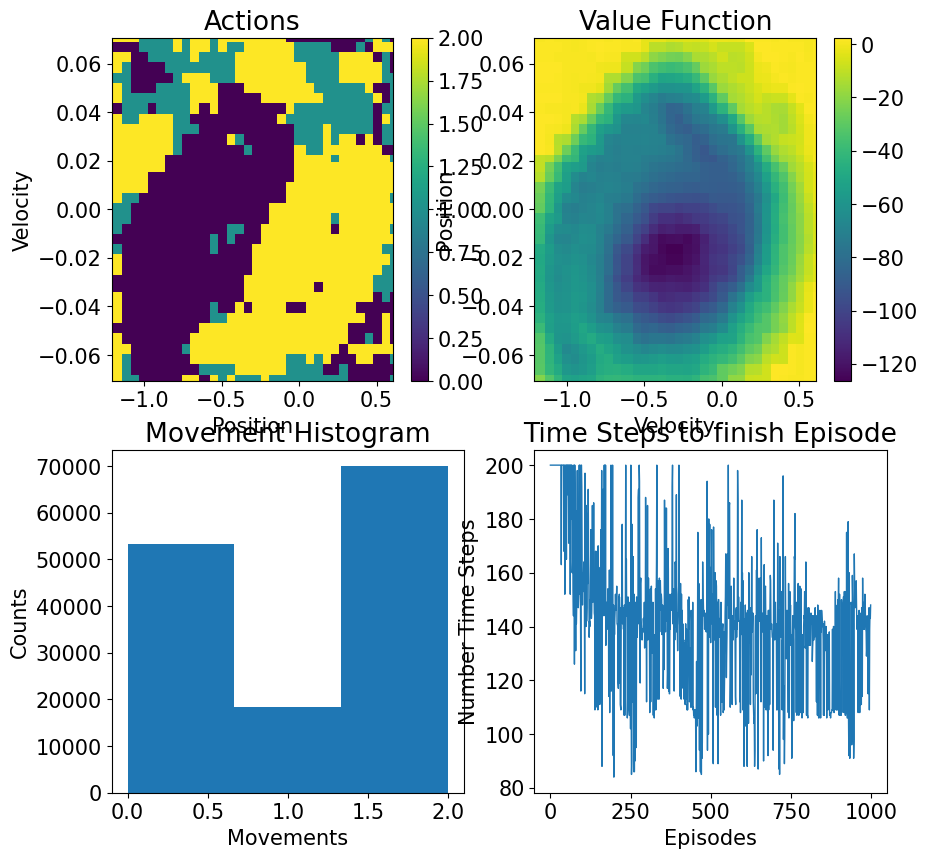

In [18]:
np.random.seed(10)
random.seed(10)
env.seed(10)

n = 100

movements = np.zeros((n,n))
value = np.zeros((n,n,3))

# walk over position
for p_i,p in enumerate(np.linspace(-1.2,0.6,n)):
    # walk over velocity
    for v_i,v in enumerate(np.linspace(-0.07,0.07,n)):
        movements[p_i,v_i] = agent.greedy_move([p,v], 100)
        # walk over actions
        for i in range(3):
            value[p_i,v_i,i] = agent.get_action_value([p,v],i)

# plot the results
fig =plt.figure(figsize=(10,10))
axes = fig.subplots(2,2,squeeze=False)


ax = axes[0,0]
c = ax.pcolor(np.linspace(-1.2,0.6,n),np.linspace(-0.07,0.07,n),movements, shading='auto',vmin=0,vmax=2)
ax.set_ylabel('Velocity')
ax.set_xlabel('Position')
ax.set_title('Actions')
plt.colorbar(c, ax = ax)


ax = axes[0,1]
c = ax.pcolor(np.linspace(-1.2,0.6,n),np.linspace(-0.07,0.07,n),value.min(2), shading='auto')
ax.set_xlabel('Velocity')
ax.set_ylabel('Position')
ax.set_title('Value Function')
plt.colorbar(c, ax = ax)


ax = axes[1,0]
ax.hist(all_actions,bins=3)
ax.set_xlabel('Movements')
ax.set_ylabel('Counts')
ax.set_title('Movement Histogram')


ax = axes[1,1]
ax.plot(range(n_episodes),ts_per_episode)
ax.set_xlabel('Episodes')
ax.set_ylabel('Number Time Steps')
ax.set_title('Time Steps to finish Episode')

plt.show()

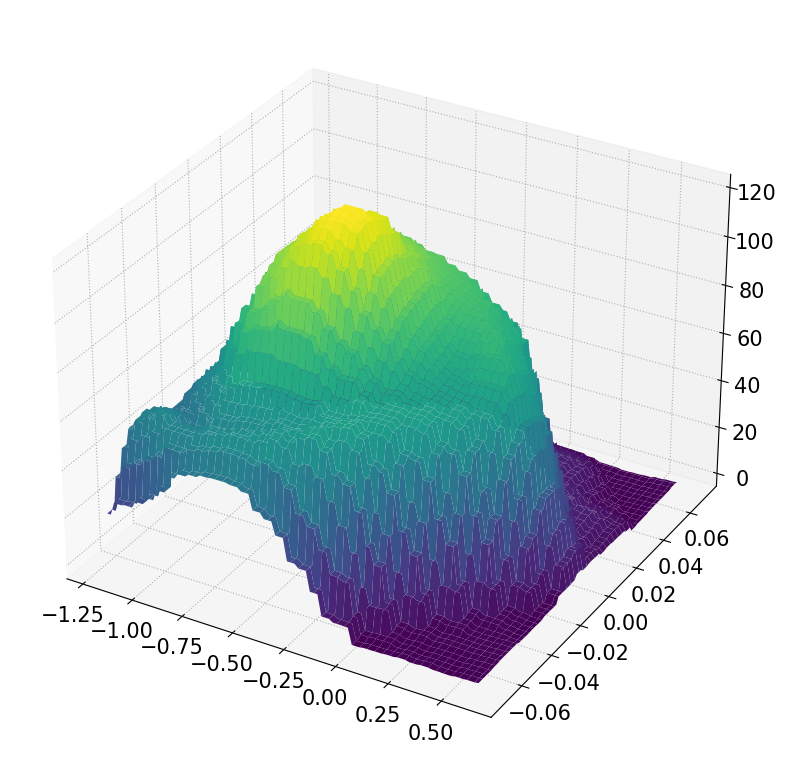

In [19]:
fig = plt.figure(figsize=(10,10))
ax = fig.subplots(subplot_kw={"projection": "3d"})

# n = 1000
# value = np.zeros((n,n,3))
X = np.linspace(-1.2,0.6,n)
Y = np.linspace(-0.07,0.07,n)
# # walk over position
# for p_i,p in enumerate(X):
#     # walk over velocity
#     for v_i,v in enumerate(Y):
#         # walk over actions
#         for i in range(3):
#             value[p_i,v_i,i] = agent.get_action_value([p,v],i)
# # Make data.
X = np.linspace(-1.2,0.6,n)
Y = np.linspace(-0.07,0.07,n)
X, Y = np.meshgrid(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, -value.mean(2).T, linewidth=0, cmap='viridis', antialiased=True)


plt.show()



## Test runs

In [11]:
# how many episodes should be played
n_episodes = 2
# initialize the agent. let it know the number of states and actions

ts_per_episode = np.zeros(n_episodes)


# Incremental MC updates
# Play one episode then update V(s)
for k in range(n_episodes):
    # reset counter
    i = 0
    # set the initial state
    s = env.reset()
    # choose initial action of the agent
    a = agent.greedy_move(s,1000)
    # play until environment tells you that the game is over
    goal_reached = False
    # run the policy iteration until goal is reached
    while not goal_reached:
        i += 1
        # execute movement
        s,r,goal_reached,_ = env.step(a)
        a = agent.greedy_move(s,100000)

        # correct reward signal
        if s[0]>=0.5:
            print('goal reached')
        
        if k > n_episodes-2:
            env.render()
            time.sleep(0.01)        
        
        
#     print(agent.get_action_value(s,a))
    
    # save the neede time steps
    ts_per_episode[k] = i        

    




   


goal reached
goal reached
